# Get Started of ∇-Prox Training

## Unrolling

In [1]:
import torch
import torch.nn as nn
from dprox import *
from dprox.utils import *
from dprox.contrib.optic import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
x = Variable()
y = Placeholder()
PSF = Placeholder()
data_term = sum_squares(conv_doe(x, PSF, circular=True), y)
reg_term = deep_prior(x, denoiser='ffdnet_color')
solver = compile(data_term + reg_term, method='admm')

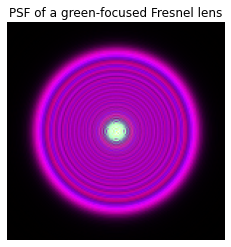

In [3]:
doe_model = build_doe_model().to(device)
psf = doe_model.get_psf()
psf_original = crop_center_region(normalize_psf(to_ndarray(psf, debatch=True), clip_percentile=0.01))
imshow(psf_original, titles=["PSF of a green-focused Fresnel lens"])

In [4]:
max_iter = 10
sigma = 7.65 / 255.
rhos, lams = log_descent(49, 7.65, max_iter, sigma=max(0.255 / 255, sigma))
doe_model.rhos = nn.parameter.Parameter(rhos)
doe_model.lams = nn.parameter.Parameter(lams)

solver = specialize(solver, method='unroll', max_iter=max_iter)

def step_fn(gt):
    gt = gt.to(device).float()
    psf = doe_model.get_psf()
    inp = img_psf_conv(gt, psf, circular=True)
    inp = inp + torch.randn(*inp.shape, device=inp.device) * sigma
    y.value = inp
    PSF.value = psf

    out = solver.solve(x0=inp, rhos=doe_model.rhos, lams={reg_term: doe_model.lams.sqrt()})
    return gt, inp, out


In [6]:
train(model=doe_model, step_fn=step_fn, dataset='BSD500', epochs=1)

Epcoh[0]:   0%|          | 0/100 [00:00<?, ?it/s]/home/laizeqiang/miniconda3/envs/torch1.10/lib/python3.7/site-packages/torch/autograd/__init__.py:175: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/Copy.cpp:239.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass
Epcoh[0]: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s, loss=0.0024, psnr=27.3823]


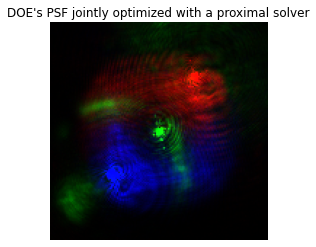

In [7]:
psf = doe_model.get_psf()
psf_dprox = crop_center_region(normalize_psf(to_ndarray(psf, debatch=True), clip_percentile=0.01))
imshow(psf_dprox, titles=["DOE's PSF jointly optimized with a proximal solver"])

## Reinforcement Learning

In [8]:
from scipy.io import loadmat
from pathlib import Path
from tfpnp.utils.noise import GaussianModelD

from dprox import *
from dprox.algo.tune import *
from dprox.utils import *
from dprox.contrib.csmri import EvalDataset, TrainDataset

In [9]:
examples_root = Path(hf.download_dataset('examples', force_download=False))
train_root = Path(hf.download_dataset('Images128', force_download=False))
val_root = Path(hf.download_dataset('Medical_7_2020', force_download=False))

In [10]:
mask_dir = examples_root / 'csmri/masks'
sigma_ns = [5, 10, 15]
sampling_masks = ['radial_128_2', 'radial_128_4', 'radial_128_8']

noise_model = GaussianModelD(sigma_ns)
masks = [loadmat(str(mask_dir / f'{sampling_mask}.mat')).get('mask')
         for sampling_mask in sampling_masks]
dataset = TrainDataset(train_root, fns=None, masks=masks, noise_model=noise_model)

valid_datasets = {
    'Medical_7_2020/radial_128_2/15': EvalDataset(val_root / 'radial_128_2/15'),
    'Medical_7_2020/radial_128_4/15': EvalDataset(val_root / 'radial_128_4/15'),
    'Medical_7_2020/radial_128_8/15': EvalDataset(val_root / 'radial_128_8/15'),
}

In [11]:
x = Variable()
y = Placeholder()
mask = Placeholder()
data_term = csmri(x, mask, y)
reg_term = deep_prior(x, denoiser='unet')
solver = compile(reg_term + data_term, method='admm')
placeholders = {'y': y, 'mask': mask}

rl_solver = specialize(solver, method='rl', policy='resnet', ob_dim=5)
train(rl_solver,
      dataset=dataset,
      valid_datasets=valid_datasets,
      placeholders=placeholders,
      train_steps=60,
      validate_interval=10)


#0: Steps: 6 - RPM[119/14400] | interval_time: 0.61 | train_time: 0.00 | Q: 0.00 | dist_entropy: 0.00 | critic_loss: 0.00
#1: Steps: 12 - RPM[217/14400] | interval_time: 0.50 | train_time: 0.00 | Q: 0.00 | dist_entropy: 0.00 | critic_loss: 0.00
#2: Steps: 17 - RPM[301/14400] | interval_time: 0.43 | train_time: 0.00 | Q: 0.00 | dist_entropy: 0.00 | critic_loss: 0.00
#3: Steps: 23 - RPM[382/14400] | interval_time: 0.42 | train_time: 4.35 | Q: 3.89 | dist_entropy: 0.32 | closs: 4.80 | anorm: 17.52 | cnorm: 37.61
#4: Steps: 29 - RPM[516/14400] | interval_time: 0.63 | train_time: 4.34 | Q: 3.67 | dist_entropy: 0.45 | closs: 3.89 | anorm: 17.54 | cnorm: 26.83
#5: Steps: 35 - RPM[597/14400] | interval_time: 0.40 | train_time: 4.35 | Q: 3.77 | dist_entropy: 0.57 | closs: 3.32 | anorm: 10.55 | cnorm: 19.06
#6: Steps: 41 - RPM[685/14400] | interval_time: 0.45 | train_time: 4.36 | Q: 3.71 | dist_entropy: 0.59 | closs: 3.76 | anorm: 8.87 | cnorm: 27.53
#7: Steps: 47 - RPM[771/14400] | interval_tim

/media/exthdd/laizeqiang/lzq/projects/tfpnp/tfpnp2/tfpnp/utils/visualize.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  img = np.clip(img, 0, 255).astype(np.uint8)


Step_0000058: Medical_7_2020/radial_128_2/15 | iters: 1.00 | psnr: 26.57 | psnr_init: 26.12 | time: 0.02 | 
Step_0000058: Medical_7_2020/radial_128_4/15 | iters: 1.00 | psnr: 26.57 | psnr_init: 24.26 | time: 0.02 | 
Step_0000058: Medical_7_2020/radial_128_8/15 | iters: 1.00 | psnr: 24.36 | psnr_init: 22.06 | time: 0.02 | 
#9: Steps: 59 - RPM[959/14400] | interval_time: 5.16 | train_time: 4.37 | Q: 3.45 | dist_entropy: 0.59 | closs: 2.73 | anorm: 11.76 | cnorm: 9.11
Step_0000059: Medical_7_2020/radial_128_2/15 | iters: 1.00 | psnr: 25.27 | psnr_init: 26.12 | time: 0.02 | 
Step_0000059: Medical_7_2020/radial_128_4/15 | iters: 1.00 | psnr: 25.99 | psnr_init: 24.26 | time: 0.02 | 
Step_0000059: Medical_7_2020/radial_128_8/15 | iters: 1.00 | psnr: 24.51 | psnr_init: 22.06 | time: 0.02 | 
Saving model at Step_0000060...
